In [1]:
import pandas as pd
import zipfile
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
from datetime import datetime

class AneurysmDICOMVisualizer:
    def __init__(self):
        """Initialize the visualizer with correct paths"""
        # Set up paths
        self.base_path = r'C:\Users\Rayan\Desktop\Main Project'
        self.zip_path = os.path.join(self.base_path, 'rsna-intracranial-aneurysm-detection.zip')
        self.code_path = os.path.join(self.base_path, 'Code')
        self.output_path = os.path.join(self.code_path, 'outputs')
        
        # Create directories if they don't exist
        for path in [self.code_path, self.output_path]:
            if not os.path.exists(path):
                os.makedirs(path)
        
        self.df_train = None
        self.df_localizer = None
        self.load_data()
    
    def load_data(self):
        """Load train.csv and train_localizers.csv from zip file"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # Load train.csv
                with zip_ref.open('train.csv') as file:
                    self.df_train = pd.read_csv(file)
                
                # Load train_localizers.csv
                with zip_ref.open('train_localizers.csv') as file:
                    self.df_localizer = pd.read_csv(file)
            
            print("✅ Data loaded successfully!")
            print(f"   Train data: {self.df_train.shape[0]} records")
            print(f"   Localizer data: {self.df_localizer.shape[0]} records")
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
    
    def get_series_info(self, series_instance_uid):
        """Get comprehensive information about a series"""
        # Get train data for this series
        train_info = self.df_train[self.df_train['SeriesInstanceUID'] == series_instance_uid]
        
        if train_info.empty:
            return None
        
        # Get localizer data for this series
        localizer_info = self.df_localizer[self.df_localizer['SeriesInstanceUID'] == series_instance_uid]
        
        # Define aneurysm columns
        aneurysm_columns = [
            'Left Infraclinoid Internal Carotid Artery',
            'Right Infraclinoid Internal Carotid Artery', 
            'Left Supraclinoid Internal Carotid Artery',
            'Right Supraclinoid Internal Carotid Artery',
            'Left Middle Cerebral Artery',
            'Right Middle Cerebral Artery',
            'Anterior Communicating Artery',
            'Left Anterior Cerebral Artery',
            'Right Anterior Cerebral Artery',
            'Left Posterior Communicating Artery',
            'Right Posterior Communicating Artery',
            'Basilar Tip',
            'Other Posterior Circulation'
        ]
        
        # Count aneurysms and find specific locations
        train_row = train_info.iloc[0]
        aneurysm_count = int(train_row[aneurysm_columns].sum())
        
        # Find specific aneurysm locations from train data
        aneurysm_locations_train = []
        for col in aneurysm_columns:
            if train_row[col] == 1:
                aneurysm_locations_train.append(col)
        
        # Get localizer details
        localizer_details = []
        if not localizer_info.empty:
            for idx, row in localizer_info.iterrows():
                localizer_details.append({
                    'SOPInstanceUID': row['SOPInstanceUID'],
                    'coordinates': row['coordinates'],
                    'location': row['location']
                })
        
        series_info = {
            'SeriesInstanceUID': series_instance_uid,
            'PatientAge': train_row['PatientAge'],
            'PatientSex': train_row['PatientSex'],
            'Modality': train_row['Modality'],
            'AneurysmPresent': train_row['Aneurysm Present'],
            'AneurysmCount': aneurysm_count,
            'AneurysmLocationsTrain': aneurysm_locations_train,
            'LocalizerDetails': localizer_details
        }
        
        return series_info
    
    def display_series_info(self, series_instance_uid):
        """Display detailed information about a series"""
        info = self.get_series_info(series_instance_uid)
        
        if info is None:
            print(f"\n❌ SeriesInstanceUID not found: {series_instance_uid}")
            return None
        
        print("\n" + "="*100)
        print(f"📊 SERIES INFORMATION")
        print("="*100)
        print(f"SeriesInstanceUID : {info['SeriesInstanceUID']}")
        print(f"Patient Age       : {info['PatientAge']} years")
        print(f"Patient Sex       : {info['PatientSex']}")
        print(f"Modality          : {info['Modality']}")
        print(f"Aneurysm Present  : {'Yes' if info['AneurysmPresent'] else 'No'}")
        print(f"Number of Locations: {info['AneurysmCount']}")
        
        if info['AneurysmLocationsTrain']:
            print(f"\n🎯 Aneurysm Locations (from training data):")
            for i, location in enumerate(info['AneurysmLocationsTrain'], 1):
                print(f"   {i}. {location}")
        
        if info['LocalizerDetails']:
            print(f"\n📍 Localizer Annotations ({len(info['LocalizerDetails'])} slice(s) with annotations):")
            for i, detail in enumerate(info['LocalizerDetails'], 1):
                print(f"\n   Slice {i}:")
                print(f"      SOPInstanceUID: {detail['SOPInstanceUID']}")
                print(f"      Coordinates   : {detail['coordinates']}")
                print(f"      Location      : {detail['location']}")
        else:
            print(f"\n⚠️ No localizer annotations found for this series")
        
        print("="*100)
        return info
    
    def show_location_menu(self, info):
        """Show menu for location selection"""
        if not info['LocalizerDetails']:
            print("\n⚠️ No localizer data available for visualization")
            return None
        
        print("\n" + "="*100)
        print("📋 LOCATION SELECTION MENU")
        print("="*100)
        
        # Get unique locations
        unique_locations = list(set([detail['location'] for detail in info['LocalizerDetails']]))
        
        print(f"\nAvailable locations in localizer data:")
        for i, location in enumerate(unique_locations, 1):
            # Count how many slices have this location
            count = sum(1 for d in info['LocalizerDetails'] if d['location'] == location)
            print(f"   {i}. {location} ({count} slice(s))")
        
        print(f"\n   0. ALL LOCATIONS (Process all {len(info['LocalizerDetails'])} annotated slices)")
        print("="*100)
        
        while True:
            try:
                choice = input("\nEnter your choice (0 for all, or location number): ").strip()
                choice = int(choice)
                
                if choice == 0:
                    return 'ALL'
                elif 1 <= choice <= len(unique_locations):
                    selected_location = unique_locations[choice - 1]
                    return selected_location
                else:
                    print(f"❌ Invalid choice. Please enter a number between 0 and {len(unique_locations)}")
            except ValueError:
                print("❌ Invalid input. Please enter a number.")
    
    def parse_coordinates(self, coord_string):
        """Parse coordinate string to extract x, y, width, height"""
        try:
            coord_string = coord_string.strip()
            if coord_string.startswith("{'x':"):
                import ast
                coord_dict = ast.literal_eval(coord_string)
                return coord_dict['x'], coord_dict['y'], coord_dict.get('width', 50), coord_dict.get('height', 50)
            elif coord_string.startswith('['):
                coords = coord_string.strip('[]').split(',')
                coords = [float(c.strip()) for c in coords]
                if len(coords) >= 2:
                    x, y = coords[0], coords[1]
                    w = coords[2] if len(coords) > 2 else 50
                    h = coords[3] if len(coords) > 3 else 50
                    return x, y, w, h
            return None
        except Exception as e:
            print(f"⚠️ Error parsing coordinates: {e}")
            return None
    
    def find_dicom_file(self, series_instance_uid, sop_instance_uid):
        """Find DICOM file in the series folder within the zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                all_files = zip_ref.namelist()
                series_files = [f for f in all_files if f'series/{series_instance_uid}/' in f and f.endswith('.dcm')]
                
                if not series_files:
                    return None
                
                for dcm_file in series_files:
                    try:
                        with zip_ref.open(dcm_file) as file:
                            ds = pydicom.dcmread(file)
                            if ds.SOPInstanceUID == sop_instance_uid:
                                return dcm_file
                    except:
                        continue
                
                if series_files:
                    return series_files[0]
                
                return None
        except Exception as e:
            print(f"❌ Error finding DICOM: {e}")
            return None
    
    def load_dicom_from_zip(self, dcm_file_path):
        """Load DICOM file directly from zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                with zip_ref.open(dcm_file_path) as file:
                    ds = pydicom.dcmread(file)
                    return ds
        except Exception as e:
            print(f"❌ Error loading DICOM: {e}")
            return None
    
    def visualize_slice(self, series_info, sop_instance_uid, location, slice_num, total_slices):
        """Visualize a single DICOM slice with annotations"""
        
        # Find and load DICOM file
        dcm_file_path = self.find_dicom_file(series_info['SeriesInstanceUID'], sop_instance_uid)
        if dcm_file_path is None:
            print(f"⚠️ DICOM file not found for SOP: {sop_instance_uid}")
            return None
        
        ds = self.load_dicom_from_zip(dcm_file_path)
        if ds is None:
            return None
        
        # Get image data
        image = ds.pixel_array
        
        # Apply window/level if available
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            center = ds.WindowCenter
            width = ds.WindowWidth
            
            if isinstance(center, pydicom.multival.MultiValue):
                center = center[0]
            if isinstance(width, pydicom.multival.MultiValue):
                width = width[0]
            
            img_min = center - width // 2
            img_max = center + width // 2
            image = np.clip(image, img_min, img_max)
            image = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        ax.imshow(image, cmap='gray')
        
        # Find coordinates for this SOP
        coord_data = []
        for detail in series_info['LocalizerDetails']:
            if detail['SOPInstanceUID'] == sop_instance_uid:
                parsed_coords = self.parse_coordinates(detail['coordinates'])
                if parsed_coords:
                    x, y, w, h = parsed_coords
                    coord_data.append({
                        'x': float(x), 'y': float(y), 
                        'width': float(w), 'height': float(h),
                        'location': detail['location']
                    })
                    
                    # Draw rectangle around aneurysm
                    rect = patches.Rectangle((x, y), w, h, 
                                           linewidth=3, 
                                           edgecolor='red', 
                                           facecolor='none', 
                                           alpha=0.9)
                    ax.add_patch(rect)
                    
                    # Draw center point
                    center_x, center_y = x + w/2, y + h/2
                    ax.plot(center_x, center_y, 'x', color='red', markersize=15, markeredgewidth=3)
                    
                    # Add crosshair at center
                    ax.plot([x, x+w], [center_y, center_y], 'r--', linewidth=2, alpha=0.7)
                    ax.plot([center_x, center_x], [y, y+h], 'r--', linewidth=2, alpha=0.7)
                    
                    # Add label with background
                    ax.text(x, y-15, detail['location'], 
                           color='white', fontsize=11, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.7", facecolor='red', 
                                   edgecolor='white', linewidth=2, alpha=0.9))
                    
                    # Add coordinate info
                    coord_text = f"Center: ({center_x:.1f}, {center_y:.1f})"
                    ax.text(x+w+5, y+h/2, coord_text, 
                           color='yellow', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        
        # Set title
        title = f"Slice {slice_num}/{total_slices} - Location: {location}\n"
        title += f"Series: {series_info['SeriesInstanceUID'][:40]}...\n"
        title += f"SOP: {sop_instance_uid[:40]}..."
        ax.set_title(title, fontsize=12, fontweight='bold', pad=20, 
                    bbox=dict(boxstyle="round,pad=0.8", facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel(f"Patient: {series_info['PatientAge']}y {series_info['PatientSex']} | "
                     f"Modality: {series_info['Modality']}", fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        
        return fig, coord_data
    
    def process_visualizations(self, series_instance_uid, selected_location):
        """Process and save visualizations based on selection"""
        
        info = self.get_series_info(series_instance_uid)
        if info is None or not info['LocalizerDetails']:
            return
        
        # Filter localizer details based on selection
        if selected_location == 'ALL':
            details_to_process = info['LocalizerDetails']
            print(f"\n🖼️ Processing ALL {len(details_to_process)} annotated slices...")
        else:
            details_to_process = [d for d in info['LocalizerDetails'] if d['location'] == selected_location]
            print(f"\n🖼️ Processing {len(details_to_process)} slice(s) for location: {selected_location}")
        
        if not details_to_process:
            print("❌ No slices found for the selected location")
            return
        
        # Create output report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_filename = f"aneurysm_report_{series_instance_uid[:20]}_{timestamp}.txt"
        report_path = os.path.join(self.output_path, report_filename)
        
        all_coordinates = []
        
        with open(report_path, 'w') as report_file:
            # Write header
            report_file.write("="*100 + "\n")
            report_file.write("ANEURYSM DETECTION REPORT\n")
            report_file.write("="*100 + "\n")
            report_file.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            report_file.write(f"SeriesInstanceUID: {info['SeriesInstanceUID']}\n")
            report_file.write(f"Patient: {info['PatientAge']}y {info['PatientSex']}\n")
            report_file.write(f"Modality: {info['Modality']}\n")
            report_file.write(f"Aneurysm Locations (Training): {', '.join(info['AneurysmLocationsTrain'])}\n")
            report_file.write(f"Selected Filter: {selected_location}\n")
            report_file.write(f"Total Slices Processed: {len(details_to_process)}\n")
            report_file.write("="*100 + "\n\n")
            
            # Process each slice
            for i, detail in enumerate(details_to_process, 1):
                print(f"   Processing slice {i}/{len(details_to_process)}...", end=' ')
                
                # Visualize
                result = self.visualize_slice(
                    info, 
                    detail['SOPInstanceUID'], 
                    detail['location'],
                    i, 
                    len(details_to_process)
                )
                
                if result:
                    fig, coord_data = result
                    
                    # Save figure to file
                    img_filename = f"slice_{i}_{detail['location'].replace(' ', '_')}_{detail['SOPInstanceUID'][:15]}.png"
                    img_path = os.path.join(self.output_path, img_filename)
                    fig.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')
                    
                    # Display in Jupyter notebook
                    print(f"✅ Saved & Displayed")
                    plt.show()
                    plt.close(fig)
                    
                    # Write to report
                    report_file.write(f"SLICE {i}\n")
                    report_file.write(f"{'='*80}\n")
                    report_file.write(f"SOPInstanceUID: {detail['SOPInstanceUID']}\n")
                    report_file.write(f"Location: {detail['location']}\n")
                    report_file.write(f"Raw Coordinates: {detail['coordinates']}\n")
                    
                    if coord_data:
                        report_file.write(f"Parsed Coordinates:\n")
                        for coord in coord_data:
                            report_file.write(f"   - X: {coord['x']:.2f}, Y: {coord['y']:.2f}, "
                                            f"Width: {coord['width']:.2f}, Height: {coord['height']:.2f}\n")
                            report_file.write(f"     Location Label: {coord['location']}\n")
                            all_coordinates.append({
                                'slice': int(i),
                                'sop_id': str(detail['SOPInstanceUID']),
                                'x': float(coord['x']),
                                'y': float(coord['y']),
                                'width': float(coord['width']),
                                'height': float(coord['height']),
                                'location': str(coord['location'])
                            })
                    
                    report_file.write(f"Image Saved: {img_filename}\n")
                    report_file.write("\n")
                else:
                    print(f"❌ Failed")
        
        # Save coordinates as JSON with proper type conversion
        json_filename = f"coordinates_{series_instance_uid[:20]}_{timestamp}.json"
        json_path = os.path.join(self.output_path, json_filename)
        with open(json_path, 'w') as json_file:
            json.dump({
                'series_info': {
                    'SeriesInstanceUID': str(info['SeriesInstanceUID']),
                    'PatientAge': int(info['PatientAge']) if pd.notna(info['PatientAge']) else None,
                    'PatientSex': str(info['PatientSex']),
                    'Modality': str(info['Modality']),
                    'AneurysmLocations': [str(loc) for loc in info['AneurysmLocationsTrain']]
                },
                'coordinates': all_coordinates
            }, json_file, indent=2)
        
        print(f"\n✅ Processing complete!")
        print(f"📄 Report saved: {report_path}")
        print(f"📊 Coordinates saved: {json_path}")
        print(f"📁 All files saved in: {self.output_path}")
    
    def interactive_mode(self):
        """Run in interactive mode with menu"""
        print("\n" + "="*100)
        print("🏥 RSNA INTRACRANIAL ANEURYSM DETECTION - INTERACTIVE VISUALIZER")
        print("="*100)
        
        while True:
            print("\n" + "-"*100)
            series_id = input("\nEnter SeriesInstanceUID (or 'quit' to exit): ").strip()
            
            if series_id.lower() == 'quit':
                print("\n👋 Exiting... Goodbye!")
                break
            
            # Display series information
            info = self.display_series_info(series_id)
            
            if info is None:
                continue
            
            if not info['LocalizerDetails']:
                print("\n⚠️ No localizer data available for this series. Cannot visualize.")
                continue
            
            # Show location menu
            selected_location = self.show_location_menu(info)
            
            if selected_location is None:
                continue
            
            # Process visualizations
            self.process_visualizations(series_id, selected_location)
            
            print("\n" + "-"*100)


# Main execution
if __name__ == "__main__":
    visualizer = AneurysmDICOMVisualizer()
    visualizer.interactive_mode()

KeyboardInterrupt: 

<h1>V2</h1>

✅ Data loaded successfully!
   Train data: 4348 records
   Localizer data: 2251 records

🏥 RSNA INTRACRANIAL ANEURYSM DETECTION - INTERACTIVE VISUALIZER

----------------------------------------------------------------------------------------------------



Enter SeriesInstanceUID (or 'quit' to exit):  1.2.826.0.1.3680043.8.498.10035782880104673269567641444954004745



📊 SERIES INFORMATION
SeriesInstanceUID : 1.2.826.0.1.3680043.8.498.10035782880104673269567641444954004745
Patient Age       : 26 years
Patient Sex       : Female
Modality          : MRA
Aneurysm Present  : No
Number of Locations: 0

⚠️ No localizer annotations found for this series

⚠️ No localizer data available for this series. Cannot visualize.

----------------------------------------------------------------------------------------------------



Enter SeriesInstanceUID (or 'quit' to exit):  1.2.826.0.1.3680043.8.498.10242908234090194014051186313014188903



📊 SERIES INFORMATION
SeriesInstanceUID : 1.2.826.0.1.3680043.8.498.10242908234090194014051186313014188903
Patient Age       : 73 years
Patient Sex       : Female
Modality          : MRA
Aneurysm Present  : Yes
Number of Locations: 1

🎯 Aneurysm Locations (from training data):
   1. Right Middle Cerebral Artery

📍 Localizer Annotations (1 slice(s) with annotations):

   Slice 1:
      SOPInstanceUID: 1.2.826.0.1.3680043.8.498.10978209953037744086830995192466328920
      Coordinates   : {'x': 197.6182742744475, 'y': 213.95564711225092}
      Location      : Right Middle Cerebral Artery

📋 LOCATION SELECTION MENU

Available locations in localizer data:
   1. Right Middle Cerebral Artery (1 slice(s))

   0. ALL LOCATIONS (Process all 1 annotated slices)



Enter your choice (0 for all, or location number):  1



🖼️ Processing 1 slice(s) for location: Right Middle Cerebral Artery

📊 Processing Slice 1/1
   Location: Right Middle Cerebral Artery
   SOP: 1.2.826.0.1.3680043.8.498.10978209953037...
   📺 Displaying raw DICOM in notebook...


C:\Users\Rayan\AppData\Local\Temp\ipykernel_21920\4049589487.py:279: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  plt.tight_layout()
C:\Users\Rayan\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


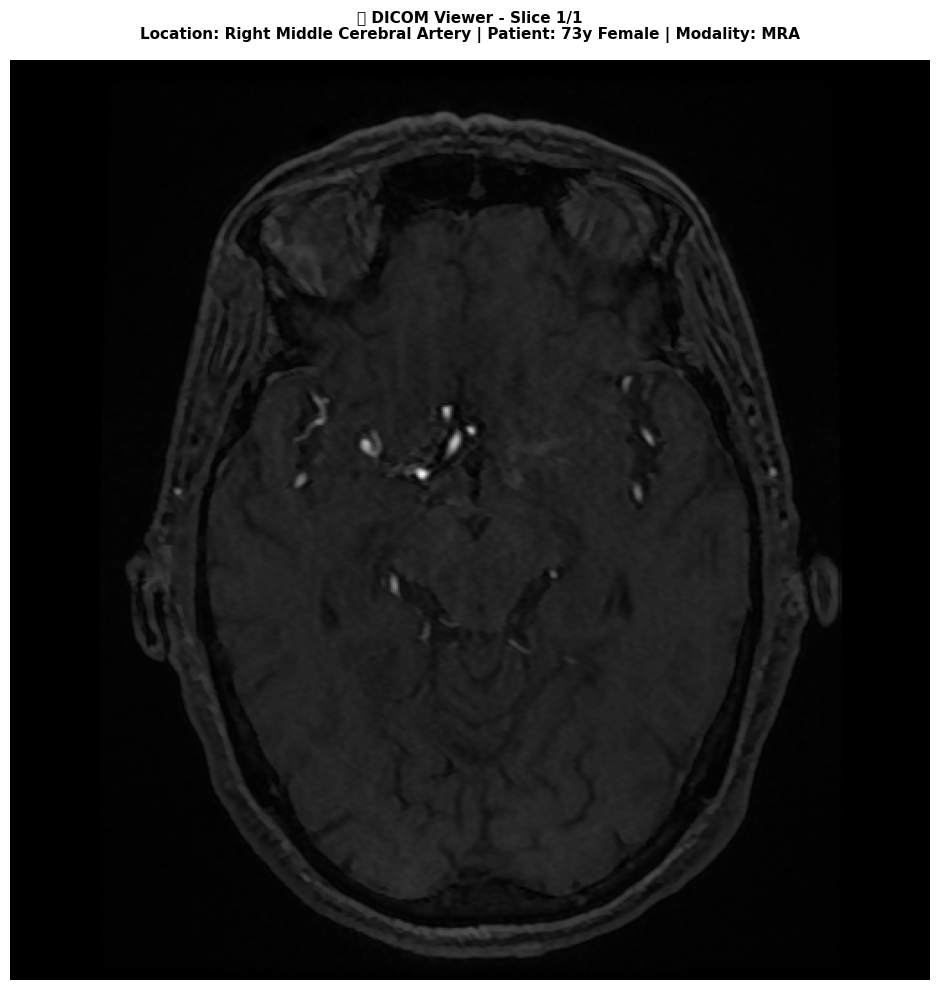

   💾 Creating annotated image for file... 

C:\Users\Rayan\AppData\Local\Temp\ipykernel_21920\4049589487.py:361: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\Rayan\AppData\Local\Temp\ipykernel_21920\4049589487.py:439: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')


✅ Saved

✅ Processing complete!
📄 Report saved: C:\Users\Rayan\Desktop\Main Project\Code\outputs\aneurysm_report_1.2.826.0.1.3680043._20251006_110334.txt
📊 Coordinates saved: C:\Users\Rayan\Desktop\Main Project\Code\outputs\coordinates_1.2.826.0.1.3680043._20251006_110334.json
📁 All files saved in: C:\Users\Rayan\Desktop\Main Project\Code\outputs

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import zipfile
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
from datetime import datetime

class AneurysmDICOMVisualizer:
    def __init__(self):
        """Initialize the visualizer with correct paths"""
        # Set up paths
        self.base_path = r'C:\Users\Rayan\Desktop\Main Project'
        self.zip_path = os.path.join(self.base_path, 'rsna-intracranial-aneurysm-detection.zip')
        self.code_path = os.path.join(self.base_path, 'Code')
        self.output_path = os.path.join(self.code_path, 'outputs')
        
        # Create directories if they don't exist
        for path in [self.code_path, self.output_path]:
            if not os.path.exists(path):
                os.makedirs(path)
        
        self.df_train = None
        self.df_localizer = None
        self.load_data()
    
    def load_data(self):
        """Load train.csv and train_localizers.csv from zip file"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # Load train.csv
                with zip_ref.open('train.csv') as file:
                    self.df_train = pd.read_csv(file)
                
                # Load train_localizers.csv
                with zip_ref.open('train_localizers.csv') as file:
                    self.df_localizer = pd.read_csv(file)
            
            print("✅ Data loaded successfully!")
            print(f"   Train data: {self.df_train.shape[0]} records")
            print(f"   Localizer data: {self.df_localizer.shape[0]} records")
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
    
    def get_series_info(self, series_instance_uid):
        """Get comprehensive information about a series"""
        # Get train data for this series
        train_info = self.df_train[self.df_train['SeriesInstanceUID'] == series_instance_uid]
        
        if train_info.empty:
            return None
        
        # Get localizer data for this series
        localizer_info = self.df_localizer[self.df_localizer['SeriesInstanceUID'] == series_instance_uid]
        
        # Define aneurysm columns
        aneurysm_columns = [
            'Left Infraclinoid Internal Carotid Artery',
            'Right Infraclinoid Internal Carotid Artery', 
            'Left Supraclinoid Internal Carotid Artery',
            'Right Supraclinoid Internal Carotid Artery',
            'Left Middle Cerebral Artery',
            'Right Middle Cerebral Artery',
            'Anterior Communicating Artery',
            'Left Anterior Cerebral Artery',
            'Right Anterior Cerebral Artery',
            'Left Posterior Communicating Artery',
            'Right Posterior Communicating Artery',
            'Basilar Tip',
            'Other Posterior Circulation'
        ]
        
        # Count aneurysms and find specific locations
        train_row = train_info.iloc[0]
        aneurysm_count = int(train_row[aneurysm_columns].sum())
        
        # Find specific aneurysm locations from train data
        aneurysm_locations_train = []
        for col in aneurysm_columns:
            if train_row[col] == 1:
                aneurysm_locations_train.append(col)
        
        # Get localizer details
        localizer_details = []
        if not localizer_info.empty:
            for idx, row in localizer_info.iterrows():
                localizer_details.append({
                    'SOPInstanceUID': row['SOPInstanceUID'],
                    'coordinates': row['coordinates'],
                    'location': row['location']
                })
        
        series_info = {
            'SeriesInstanceUID': series_instance_uid,
            'PatientAge': train_row['PatientAge'],
            'PatientSex': train_row['PatientSex'],
            'Modality': train_row['Modality'],
            'AneurysmPresent': train_row['Aneurysm Present'],
            'AneurysmCount': aneurysm_count,
            'AneurysmLocationsTrain': aneurysm_locations_train,
            'LocalizerDetails': localizer_details
        }
        
        return series_info
    
    def display_series_info(self, series_instance_uid):
        """Display detailed information about a series"""
        info = self.get_series_info(series_instance_uid)
        
        if info is None:
            print(f"\n❌ SeriesInstanceUID not found: {series_instance_uid}")
            return None
        
        print("\n" + "="*100)
        print(f"📊 SERIES INFORMATION")
        print("="*100)
        print(f"SeriesInstanceUID : {info['SeriesInstanceUID']}")
        print(f"Patient Age       : {info['PatientAge']} years")
        print(f"Patient Sex       : {info['PatientSex']}")
        print(f"Modality          : {info['Modality']}")
        print(f"Aneurysm Present  : {'Yes' if info['AneurysmPresent'] else 'No'}")
        print(f"Number of Locations: {info['AneurysmCount']}")
        
        if info['AneurysmLocationsTrain']:
            print(f"\n🎯 Aneurysm Locations (from training data):")
            for i, location in enumerate(info['AneurysmLocationsTrain'], 1):
                print(f"   {i}. {location}")
        
        if info['LocalizerDetails']:
            print(f"\n📍 Localizer Annotations ({len(info['LocalizerDetails'])} slice(s) with annotations):")
            for i, detail in enumerate(info['LocalizerDetails'], 1):
                print(f"\n   Slice {i}:")
                print(f"      SOPInstanceUID: {detail['SOPInstanceUID']}")
                print(f"      Coordinates   : {detail['coordinates']}")
                print(f"      Location      : {detail['location']}")
        else:
            print(f"\n⚠️ No localizer annotations found for this series")
        
        print("="*100)
        return info
    
    def show_location_menu(self, info):
        """Show menu for location selection"""
        if not info['LocalizerDetails']:
            print("\n⚠️ No localizer data available for visualization")
            return None
        
        print("\n" + "="*100)
        print("📋 LOCATION SELECTION MENU")
        print("="*100)
        
        # Get unique locations
        unique_locations = list(set([detail['location'] for detail in info['LocalizerDetails']]))
        
        print(f"\nAvailable locations in localizer data:")
        for i, location in enumerate(unique_locations, 1):
            # Count how many slices have this location
            count = sum(1 for d in info['LocalizerDetails'] if d['location'] == location)
            print(f"   {i}. {location} ({count} slice(s))")
        
        print(f"\n   0. ALL LOCATIONS (Process all {len(info['LocalizerDetails'])} annotated slices)")
        print("="*100)
        
        while True:
            try:
                choice = input("\nEnter your choice (0 for all, or location number): ").strip()
                choice = int(choice)
                
                if choice == 0:
                    return 'ALL'
                elif 1 <= choice <= len(unique_locations):
                    selected_location = unique_locations[choice - 1]
                    return selected_location
                else:
                    print(f"❌ Invalid choice. Please enter a number between 0 and {len(unique_locations)}")
            except ValueError:
                print("❌ Invalid input. Please enter a number.")
    
    def parse_coordinates(self, coord_string):
        """Parse coordinate string to extract x, y, width, height"""
        try:
            coord_string = coord_string.strip()
            if coord_string.startswith("{'x':"):
                import ast
                coord_dict = ast.literal_eval(coord_string)
                return coord_dict['x'], coord_dict['y'], coord_dict.get('width', 50), coord_dict.get('height', 50)
            elif coord_string.startswith('['):
                coords = coord_string.strip('[]').split(',')
                coords = [float(c.strip()) for c in coords]
                if len(coords) >= 2:
                    x, y = coords[0], coords[1]
                    w = coords[2] if len(coords) > 2 else 50
                    h = coords[3] if len(coords) > 3 else 50
                    return x, y, w, h
            return None
        except Exception as e:
            print(f"⚠️ Error parsing coordinates: {e}")
            return None
    
    def find_dicom_file(self, series_instance_uid, sop_instance_uid):
        """Find DICOM file in the series folder within the zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                all_files = zip_ref.namelist()
                series_files = [f for f in all_files if f'series/{series_instance_uid}/' in f and f.endswith('.dcm')]
                
                if not series_files:
                    return None
                
                for dcm_file in series_files:
                    try:
                        with zip_ref.open(dcm_file) as file:
                            ds = pydicom.dcmread(file)
                            if ds.SOPInstanceUID == sop_instance_uid:
                                return dcm_file
                    except:
                        continue
                
                if series_files:
                    return series_files[0]
                
                return None
        except Exception as e:
            print(f"❌ Error finding DICOM: {e}")
            return None
    
    def load_dicom_from_zip(self, dcm_file_path):
        """Load DICOM file directly from zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                with zip_ref.open(dcm_file_path) as file:
                    ds = pydicom.dcmread(file)
                    return ds
        except Exception as e:
            print(f"❌ Error loading DICOM: {e}")
            return None
    
    def display_raw_dicom(self, ds, series_info, sop_instance_uid, location, slice_num, total_slices):
        """Display raw DICOM image without annotations in Jupyter notebook"""
        
        # Get image data
        image = ds.pixel_array
        
        # Apply window/level if available
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            center = ds.WindowCenter
            width = ds.WindowWidth
            
            if isinstance(center, pydicom.multival.MultiValue):
                center = center[0]
            if isinstance(width, pydicom.multival.MultiValue):
                width = width[0]
            
            img_min = center - width // 2
            img_max = center + width // 2
            image = np.clip(image, img_min, img_max)
            image = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        
        # Create raw DICOM viewer display
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.imshow(image, cmap='gray')
        
        # Add minimal info without markings
        title = f"📋 DICOM Viewer - Slice {slice_num}/{total_slices}\n"
        title += f"Location: {location} | Patient: {series_info['PatientAge']}y {series_info['PatientSex']} | "
        title += f"Modality: {series_info['Modality']}"
        ax.set_title(title, fontsize=11, fontweight='bold', pad=15)
        
        # Show image dimensions
        ax.set_xlabel(f"Image Size: {image.shape[1]} x {image.shape[0]} pixels | "
                     f"SOP: {sop_instance_uid[:30]}...", fontsize=9)
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    def create_annotated_image(self, ds, series_info, sop_instance_uid, location, slice_num, total_slices):
        """Create annotated image for saving to file"""
        
        # Get image data
        image = ds.pixel_array
        
        # Apply window/level if available
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            center = ds.WindowCenter
            width = ds.WindowWidth
            
            if isinstance(center, pydicom.multival.MultiValue):
                center = center[0]
            if isinstance(width, pydicom.multival.MultiValue):
                width = width[0]
            
            img_min = center - width // 2
            img_max = center + width // 2
            image = np.clip(image, img_min, img_max)
            image = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        
        # Create figure with annotations
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        ax.imshow(image, cmap='gray')
        
        # Find coordinates for this SOP and add annotations
        coord_data = []
        for detail in series_info['LocalizerDetails']:
            if detail['SOPInstanceUID'] == sop_instance_uid:
                parsed_coords = self.parse_coordinates(detail['coordinates'])
                if parsed_coords:
                    x, y, w, h = parsed_coords
                    coord_data.append({
                        'x': float(x), 'y': float(y), 
                        'width': float(w), 'height': float(h),
                        'location': detail['location']
                    })
                    
                    # Draw rectangle around aneurysm
                    rect = patches.Rectangle((x, y), w, h, 
                                           linewidth=3, 
                                           edgecolor='red', 
                                           facecolor='none', 
                                           alpha=0.9)
                    ax.add_patch(rect)
                    
                    # Draw center point
                    center_x, center_y = x + w/2, y + h/2
                    ax.plot(center_x, center_y, 'x', color='red', markersize=15, markeredgewidth=3)
                    
                    # Add crosshair at center
                    ax.plot([x, x+w], [center_y, center_y], 'r--', linewidth=2, alpha=0.7)
                    ax.plot([center_x, center_x], [y, y+h], 'r--', linewidth=2, alpha=0.7)
                    
                    # Add label with background
                    ax.text(x, y-15, detail['location'], 
                           color='white', fontsize=11, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.7", facecolor='red', 
                                   edgecolor='white', linewidth=2, alpha=0.9))
                    
                    # Add coordinate info
                    coord_text = f"Center: ({center_x:.1f}, {center_y:.1f})"
                    ax.text(x+w+5, y+h/2, coord_text, 
                           color='yellow', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        
        # Set title
        title = f"🎯 Annotated - Slice {slice_num}/{total_slices} - Location: {location}\n"
        title += f"Series: {series_info['SeriesInstanceUID'][:40]}...\n"
        title += f"SOP: {sop_instance_uid[:40]}..."
        ax.set_title(title, fontsize=12, fontweight='bold', pad=20, 
                    bbox=dict(boxstyle="round,pad=0.8", facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel(f"Patient: {series_info['PatientAge']}y {series_info['PatientSex']} | "
                     f"Modality: {series_info['Modality']}", fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        
        return fig, coord_data
    
    def process_visualizations(self, series_instance_uid, selected_location):
        """Process and save visualizations based on selection"""
        
        info = self.get_series_info(series_instance_uid)
        if info is None or not info['LocalizerDetails']:
            return
        
        # Filter localizer details based on selection
        if selected_location == 'ALL':
            details_to_process = info['LocalizerDetails']
            print(f"\n🖼️ Processing ALL {len(details_to_process)} annotated slices...")
        else:
            details_to_process = [d for d in info['LocalizerDetails'] if d['location'] == selected_location]
            print(f"\n🖼️ Processing {len(details_to_process)} slice(s) for location: {selected_location}")
        
        if not details_to_process:
            print("❌ No slices found for the selected location")
            return
        
        # Create output report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_filename = f"aneurysm_report_{series_instance_uid[:20]}_{timestamp}.txt"
        report_path = os.path.join(self.output_path, report_filename)
        
        all_coordinates = []
        
        with open(report_path, 'w') as report_file:
            # Write header
            report_file.write("="*100 + "\n")
            report_file.write("ANEURYSM DETECTION REPORT\n")
            report_file.write("="*100 + "\n")
            report_file.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            report_file.write(f"SeriesInstanceUID: {info['SeriesInstanceUID']}\n")
            report_file.write(f"Patient: {info['PatientAge']}y {info['PatientSex']}\n")
            report_file.write(f"Modality: {info['Modality']}\n")
            report_file.write(f"Aneurysm Locations (Training): {', '.join(info['AneurysmLocationsTrain'])}\n")
            report_file.write(f"Selected Filter: {selected_location}\n")
            report_file.write(f"Total Slices Processed: {len(details_to_process)}\n")
            report_file.write("="*100 + "\n\n")
            
            # Process each slice
            for i, detail in enumerate(details_to_process, 1):
                print(f"\n{'='*80}")
                print(f"📊 Processing Slice {i}/{len(details_to_process)}")
                print(f"   Location: {detail['location']}")
                print(f"   SOP: {detail['SOPInstanceUID'][:40]}...")
                
                # Find and load DICOM file
                dcm_file_path = self.find_dicom_file(info['SeriesInstanceUID'], detail['SOPInstanceUID'])
                if dcm_file_path is None:
                    print(f"   ❌ DICOM file not found")
                    continue
                
                ds = self.load_dicom_from_zip(dcm_file_path)
                if ds is None:
                    print(f"   ❌ Failed to load DICOM")
                    continue
                
                # 1. Display RAW DICOM in Jupyter notebook (no annotations)
                print(f"   📺 Displaying raw DICOM in notebook...")
                self.display_raw_dicom(ds, info, detail['SOPInstanceUID'], 
                                      detail['location'], i, len(details_to_process))
                
                # 2. Create ANNOTATED image and save to file
                print(f"   💾 Creating annotated image for file...", end=' ')
                result = self.create_annotated_image(ds, info, detail['SOPInstanceUID'],
                                                     detail['location'], i, len(details_to_process))
                
                if result:
                    fig, coord_data = result
                    
                    # Save annotated figure to file
                    img_filename = f"slice_{i}_{detail['location'].replace(' ', '_')}_{detail['SOPInstanceUID'][:15]}.png"
                    img_path = os.path.join(self.output_path, img_filename)
                    fig.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')
                    plt.close(fig)
                    
                    print(f"✅ Saved")
                    
                    # Write to report
                    report_file.write(f"SLICE {i}\n")
                    report_file.write(f"{'='*80}\n")
                    report_file.write(f"SOPInstanceUID: {detail['SOPInstanceUID']}\n")
                    report_file.write(f"Location: {detail['location']}\n")
                    report_file.write(f"Raw Coordinates: {detail['coordinates']}\n")
                    
                    if coord_data:
                        report_file.write(f"Parsed Coordinates:\n")
                        for coord in coord_data:
                            report_file.write(f"   - X: {coord['x']:.2f}, Y: {coord['y']:.2f}, "
                                            f"Width: {coord['width']:.2f}, Height: {coord['height']:.2f}\n")
                            report_file.write(f"     Location Label: {coord['location']}\n")
                            all_coordinates.append({
                                'slice': int(i),
                                'sop_id': str(detail['SOPInstanceUID']),
                                'x': float(coord['x']),
                                'y': float(coord['y']),
                                'width': float(coord['width']),
                                'height': float(coord['height']),
                                'location': str(coord['location'])
                            })
                    
                    report_file.write(f"Annotated Image Saved: {img_filename}\n")
                    report_file.write("\n")
                else:
                    print(f"❌ Failed")
        
        # Save coordinates as JSON with proper type conversion
        json_filename = f"coordinates_{series_instance_uid[:20]}_{timestamp}.json"
        json_path = os.path.join(self.output_path, json_filename)
        with open(json_path, 'w') as json_file:
            json.dump({
                'series_info': {
                    'SeriesInstanceUID': str(info['SeriesInstanceUID']),
                    'PatientAge': int(info['PatientAge']) if pd.notna(info['PatientAge']) else None,
                    'PatientSex': str(info['PatientSex']),
                    'Modality': str(info['Modality']),
                    'AneurysmLocations': [str(loc) for loc in info['AneurysmLocationsTrain']]
                },
                'coordinates': all_coordinates
            }, json_file, indent=2)
        
        print(f"\n{'='*80}")
        print(f"✅ Processing complete!")
        print(f"📄 Report saved: {report_path}")
        print(f"📊 Coordinates saved: {json_path}")
        print(f"📁 All files saved in: {self.output_path}")
        print(f"{'='*80}")
    
    def interactive_mode(self):
        """Run in interactive mode with menu"""
        print("\n" + "="*100)
        print("🏥 RSNA INTRACRANIAL ANEURYSM DETECTION - INTERACTIVE VISUALIZER")
        print("="*100)
        
        while True:
            print("\n" + "-"*100)
            series_id = input("\nEnter SeriesInstanceUID (or 'quit' to exit): ").strip()
            
            if series_id.lower() == 'quit':
                print("\n👋 Exiting... Goodbye!")
                break
            
            # Display series information
            info = self.display_series_info(series_id)
            
            if info is None:
                continue
            
            if not info['LocalizerDetails']:
                print("\n⚠️ No localizer data available for this series. Cannot visualize.")
                continue
            
            # Show location menu
            selected_location = self.show_location_menu(info)
            
            if selected_location is None:
                continue
            
            # Process visualizations
            self.process_visualizations(series_id, selected_location)
            
            print("\n" + "-"*100)


# Main execution
if __name__ == "__main__":
    visualizer = AneurysmDICOMVisualizer()
    visualizer.interactive_mode()

✅ Data loaded successfully!
   Train data: 4348 records
   Localizer data: 2251 records

🏥 RSNA INTRACRANIAL ANEURYSM DETECTION - INTERACTIVE VISUALIZER

----------------------------------------------------------------------------------------------------



Enter SeriesInstanceUID (or 'quit' to exit):  1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381



📊 SERIES INFORMATION
SeriesInstanceUID : 1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381
Patient Age       : 62 years
Patient Sex       : Female
Modality          : CTA
Aneurysm Present  : Yes
Number of Locations: 3

🎯 Aneurysm Locations (from training data):
   1. Right Supraclinoid Internal Carotid Artery
   2. Left Middle Cerebral Artery
   3. Right Anterior Cerebral Artery

📍 Localizer Annotations (3 slice(s) with annotations):

   Slice 1:
      SOPInstanceUID: 1.2.826.0.1.3680043.8.498.30083322134992576720636296296008654053
      Coordinates   : {'x': 223.66020358711827, 'y': 225.3447011195274}
      Location      : Right Anterior Cerebral Artery

   Slice 2:
      SOPInstanceUID: 1.2.826.0.1.3680043.8.498.46752468449107005352755579756056225731
      Coordinates   : {'x': 289.2376764288231, 'y': 211.78100912436958}
      Location      : Left Middle Cerebral Artery

   Slice 3:
      SOPInstanceUID: 1.2.826.0.1.3680043.8.498.14504961303532677815336995545201912867


Enter your choice (0 for all, or location number):  2



🖼️ Processing 1 slice(s) for location: Right Supraclinoid Internal Carotid Artery

📊 Processing Slice 1/1
   Location: Right Supraclinoid Internal Carotid Artery
   SOP: 1.2.826.0.1.3680043.8.498.14504961303532...
   📺 Displaying raw DICOM in notebook...


C:\Users\Rayan\AppData\Local\Temp\ipykernel_32208\4049589487.py:279: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  plt.tight_layout()
C:\Users\Rayan\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


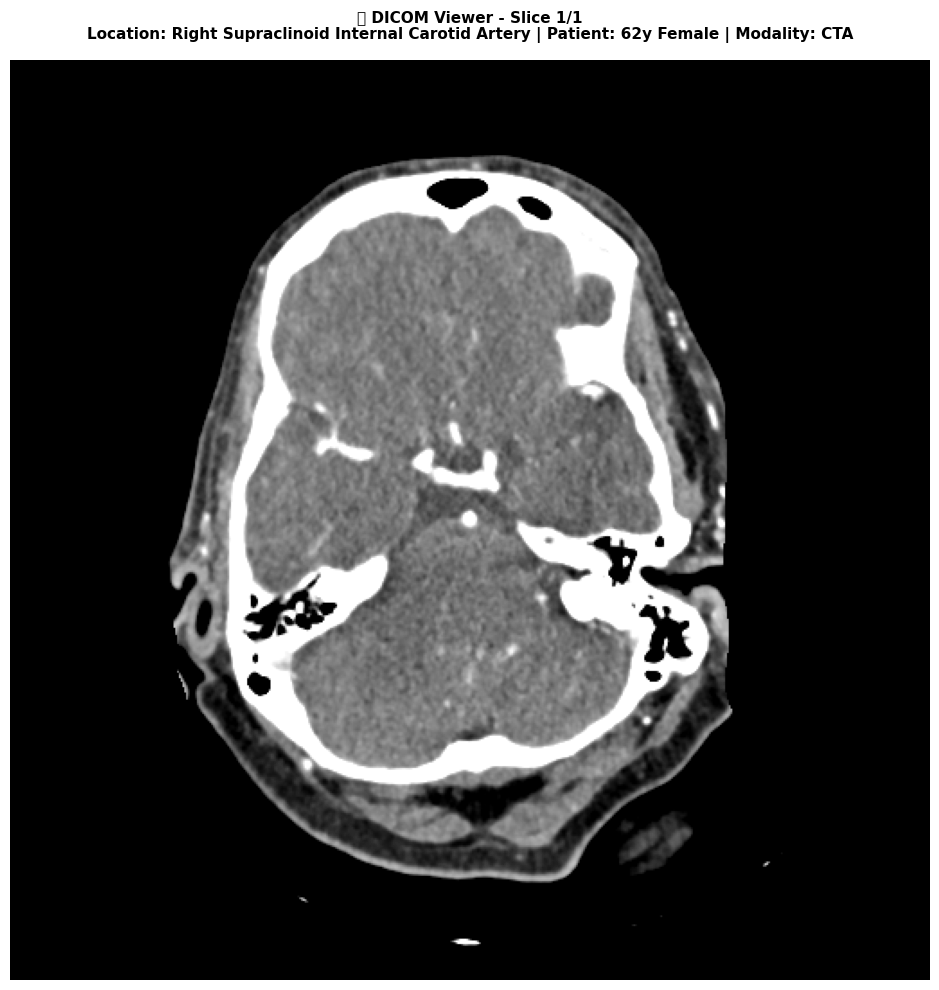

   💾 Creating annotated image for file... 

C:\Users\Rayan\AppData\Local\Temp\ipykernel_32208\4049589487.py:361: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
C:\Users\Rayan\AppData\Local\Temp\ipykernel_32208\4049589487.py:439: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')


✅ Saved

✅ Processing complete!
📄 Report saved: C:\Users\Rayan\Desktop\Main Project\Code\outputs\aneurysm_report_1.2.826.0.1.3680043._20251020_204609.txt
📊 Coordinates saved: C:\Users\Rayan\Desktop\Main Project\Code\outputs\coordinates_1.2.826.0.1.3680043._20251020_204609.json
📁 All files saved in: C:\Users\Rayan\Desktop\Main Project\Code\outputs

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import zipfile
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import json
from datetime import datetime

class AneurysmDICOMVisualizer:
    def __init__(self):
        """Initialize the visualizer with correct paths"""
        # Set up paths
        self.base_path = r'C:\Users\Rayan\Desktop\Main Project'
        self.zip_path = os.path.join(self.base_path, 'rsna-intracranial-aneurysm-detection.zip')
        self.code_path = os.path.join(self.base_path, 'Code')
        self.output_path = os.path.join(self.code_path, 'outputs')
        
        # Create directories if they don't exist
        for path in [self.code_path, self.output_path]:
            if not os.path.exists(path):
                os.makedirs(path)
        
        self.df_train = None
        self.df_localizer = None
        self.load_data()
    
    def load_data(self):
        """Load train.csv and train_localizers.csv from zip file"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # Load train.csv
                with zip_ref.open('train.csv') as file:
                    self.df_train = pd.read_csv(file)
                
                # Load train_localizers.csv
                with zip_ref.open('train_localizers.csv') as file:
                    self.df_localizer = pd.read_csv(file)
            
            print("✅ Data loaded successfully!")
            print(f"   Train data: {self.df_train.shape[0]} records")
            print(f"   Localizer data: {self.df_localizer.shape[0]} records")
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
    
    def get_series_info(self, series_instance_uid):
        """Get comprehensive information about a series"""
        # Get train data for this series
        train_info = self.df_train[self.df_train['SeriesInstanceUID'] == series_instance_uid]
        
        if train_info.empty:
            return None
        
        # Get localizer data for this series
        localizer_info = self.df_localizer[self.df_localizer['SeriesInstanceUID'] == series_instance_uid]
        
        # Define aneurysm columns
        aneurysm_columns = [
            'Left Infraclinoid Internal Carotid Artery',
            'Right Infraclinoid Internal Carotid Artery', 
            'Left Supraclinoid Internal Carotid Artery',
            'Right Supraclinoid Internal Carotid Artery',
            'Left Middle Cerebral Artery',
            'Right Middle Cerebral Artery',
            'Anterior Communicating Artery',
            'Left Anterior Cerebral Artery',
            'Right Anterior Cerebral Artery',
            'Left Posterior Communicating Artery',
            'Right Posterior Communicating Artery',
            'Basilar Tip',
            'Other Posterior Circulation'
        ]
        
        # Count aneurysms and find specific locations
        train_row = train_info.iloc[0]
        aneurysm_count = int(train_row[aneurysm_columns].sum())
        
        # Find specific aneurysm locations from train data
        aneurysm_locations_train = []
        for col in aneurysm_columns:
            if train_row[col] == 1:
                aneurysm_locations_train.append(col)
        
        # Get localizer details
        localizer_details = []
        if not localizer_info.empty:
            for idx, row in localizer_info.iterrows():
                localizer_details.append({
                    'SOPInstanceUID': row['SOPInstanceUID'],
                    'coordinates': row['coordinates'],
                    'location': row['location']
                })
        
        series_info = {
            'SeriesInstanceUID': series_instance_uid,
            'PatientAge': train_row['PatientAge'],
            'PatientSex': train_row['PatientSex'],
            'Modality': train_row['Modality'],
            'AneurysmPresent': train_row['Aneurysm Present'],
            'AneurysmCount': aneurysm_count,
            'AneurysmLocationsTrain': aneurysm_locations_train,
            'LocalizerDetails': localizer_details
        }
        
        return series_info
    
    def display_series_info(self, series_instance_uid):
        """Display detailed information about a series"""
        info = self.get_series_info(series_instance_uid)
        
        if info is None:
            print(f"\n❌ SeriesInstanceUID not found: {series_instance_uid}")
            return None
        
        print("\n" + "="*100)
        print(f"📊 SERIES INFORMATION")
        print("="*100)
        print(f"SeriesInstanceUID : {info['SeriesInstanceUID']}")
        print(f"Patient Age       : {info['PatientAge']} years")
        print(f"Patient Sex       : {info['PatientSex']}")
        print(f"Modality          : {info['Modality']}")
        print(f"Aneurysm Present  : {'Yes' if info['AneurysmPresent'] else 'No'}")
        print(f"Number of Locations: {info['AneurysmCount']}")
        
        if info['AneurysmLocationsTrain']:
            print(f"\n🎯 Aneurysm Locations (from training data):")
            for i, location in enumerate(info['AneurysmLocationsTrain'], 1):
                print(f"   {i}. {location}")
        
        if info['LocalizerDetails']:
            print(f"\n📍 Localizer Annotations ({len(info['LocalizerDetails'])} slice(s) with annotations):")
            for i, detail in enumerate(info['LocalizerDetails'], 1):
                print(f"\n   Slice {i}:")
                print(f"      SOPInstanceUID: {detail['SOPInstanceUID']}")
                print(f"      Coordinates   : {detail['coordinates']}")
                print(f"      Location      : {detail['location']}")
        else:
            print(f"\n⚠️ No localizer annotations found for this series")
        
        print("="*100)
        return info
    
    def show_location_menu(self, info):
        """Show menu for location selection"""
        if not info['LocalizerDetails']:
            print("\n⚠️ No localizer data available for visualization")
            return None
        
        print("\n" + "="*100)
        print("📋 LOCATION SELECTION MENU")
        print("="*100)
        
        # Get unique locations
        unique_locations = list(set([detail['location'] for detail in info['LocalizerDetails']]))
        
        print(f"\nAvailable locations in localizer data:")
        for i, location in enumerate(unique_locations, 1):
            # Count how many slices have this location
            count = sum(1 for d in info['LocalizerDetails'] if d['location'] == location)
            print(f"   {i}. {location} ({count} slice(s))")
        
        print(f"\n   0. ALL LOCATIONS (Process all {len(info['LocalizerDetails'])} annotated slices)")
        print("="*100)
        
        while True:
            try:
                choice = input("\nEnter your choice (0 for all, or location number): ").strip()
                choice = int(choice)
                
                if choice == 0:
                    return 'ALL'
                elif 1 <= choice <= len(unique_locations):
                    selected_location = unique_locations[choice - 1]
                    return selected_location
                else:
                    print(f"❌ Invalid choice. Please enter a number between 0 and {len(unique_locations)}")
            except ValueError:
                print("❌ Invalid input. Please enter a number.")
    
    def parse_coordinates(self, coord_string):
        """Parse coordinate string to extract x, y, width, height"""
        try:
            coord_string = coord_string.strip()
            if coord_string.startswith("{'x':"):
                import ast
                coord_dict = ast.literal_eval(coord_string)
                return coord_dict['x'], coord_dict['y'], coord_dict.get('width', 50), coord_dict.get('height', 50)
            elif coord_string.startswith('['):
                coords = coord_string.strip('[]').split(',')
                coords = [float(c.strip()) for c in coords]
                if len(coords) >= 2:
                    x, y = coords[0], coords[1]
                    w = coords[2] if len(coords) > 2 else 50
                    h = coords[3] if len(coords) > 3 else 50
                    return x, y, w, h
            return None
        except Exception as e:
            print(f"⚠️ Error parsing coordinates: {e}")
            return None
    
    def find_dicom_file(self, series_instance_uid, sop_instance_uid):
        """Find DICOM file in the series folder within the zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                all_files = zip_ref.namelist()
                series_files = [f for f in all_files if f'series/{series_instance_uid}/' in f and f.endswith('.dcm')]
                
                if not series_files:
                    return None
                
                for dcm_file in series_files:
                    try:
                        with zip_ref.open(dcm_file) as file:
                            ds = pydicom.dcmread(file)
                            if ds.SOPInstanceUID == sop_instance_uid:
                                return dcm_file
                    except:
                        continue
                
                if series_files:
                    return series_files[0]
                
                return None
        except Exception as e:
            print(f"❌ Error finding DICOM: {e}")
            return None
    
    def load_dicom_from_zip(self, dcm_file_path):
        """Load DICOM file directly from zip"""
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                with zip_ref.open(dcm_file_path) as file:
                    ds = pydicom.dcmread(file)
                    return ds
        except Exception as e:
            print(f"❌ Error loading DICOM: {e}")
            return None
    
    def display_raw_dicom(self, ds, series_info, sop_instance_uid, location, slice_num, total_slices):
        """Display raw DICOM image without annotations in Jupyter notebook"""
        
        # Get image data
        image = ds.pixel_array
        
        # Apply window/level if available
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            center = ds.WindowCenter
            width = ds.WindowWidth
            
            if isinstance(center, pydicom.multival.MultiValue):
                center = center[0]
            if isinstance(width, pydicom.multival.MultiValue):
                width = width[0]
            
            img_min = center - width // 2
            img_max = center + width // 2
            image = np.clip(image, img_min, img_max)
            image = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        
        # Create raw DICOM viewer display
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.imshow(image, cmap='gray')
        
        # Add minimal info without markings
        title = f"📋 DICOM Viewer - Slice {slice_num}/{total_slices}\n"
        title += f"Location: {location} | Patient: {series_info['PatientAge']}y {series_info['PatientSex']} | "
        title += f"Modality: {series_info['Modality']}"
        ax.set_title(title, fontsize=11, fontweight='bold', pad=15)
        
        # Show image dimensions
        ax.set_xlabel(f"Image Size: {image.shape[1]} x {image.shape[0]} pixels | "
                     f"SOP: {sop_instance_uid[:30]}...", fontsize=9)
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    def create_annotated_image(self, ds, series_info, sop_instance_uid, location, slice_num, total_slices):
        """Create annotated image for saving to file"""
        
        # Get image data
        image = ds.pixel_array
        
        # Apply window/level if available
        if hasattr(ds, 'WindowCenter') and hasattr(ds, 'WindowWidth'):
            center = ds.WindowCenter
            width = ds.WindowWidth
            
            if isinstance(center, pydicom.multival.MultiValue):
                center = center[0]
            if isinstance(width, pydicom.multival.MultiValue):
                width = width[0]
            
            img_min = center - width // 2
            img_max = center + width // 2
            image = np.clip(image, img_min, img_max)
            image = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        else:
            image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        
        # Create figure with annotations
        fig, ax = plt.subplots(1, 1, figsize=(14, 12))
        ax.imshow(image, cmap='gray')
        
        # Find coordinates for this SOP and add annotations
        coord_data = []
        for detail in series_info['LocalizerDetails']:
            if detail['SOPInstanceUID'] == sop_instance_uid:
                parsed_coords = self.parse_coordinates(detail['coordinates'])
                if parsed_coords:
                    x, y, w, h = parsed_coords
                    coord_data.append({
                        'x': float(x), 'y': float(y), 
                        'width': float(w), 'height': float(h),
                        'location': detail['location']
                    })
                    
                    # Draw rectangle around aneurysm
                    rect = patches.Rectangle((x, y), w, h, 
                                           linewidth=3, 
                                           edgecolor='red', 
                                           facecolor='none', 
                                           alpha=0.9)
                    ax.add_patch(rect)
                    
                    # Draw center point
                    center_x, center_y = x + w/2, y + h/2
                    ax.plot(center_x, center_y, 'x', color='red', markersize=15, markeredgewidth=3)
                    
                    # Add crosshair at center
                    ax.plot([x, x+w], [center_y, center_y], 'r--', linewidth=2, alpha=0.7)
                    ax.plot([center_x, center_x], [y, y+h], 'r--', linewidth=2, alpha=0.7)
                    
                    # Add label with background
                    ax.text(x, y-15, detail['location'], 
                           color='white', fontsize=11, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.7", facecolor='red', 
                                   edgecolor='white', linewidth=2, alpha=0.9))
                    
                    # Add coordinate info
                    coord_text = f"Center: ({center_x:.1f}, {center_y:.1f})"
                    ax.text(x+w+5, y+h/2, coord_text, 
                           color='yellow', fontsize=9, fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        
        # Set title
        title = f"🎯 Annotated - Slice {slice_num}/{total_slices} - Location: {location}\n"
        title += f"Series: {series_info['SeriesInstanceUID'][:40]}...\n"
        title += f"SOP: {sop_instance_uid[:40]}..."
        ax.set_title(title, fontsize=12, fontweight='bold', pad=20, 
                    bbox=dict(boxstyle="round,pad=0.8", facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel(f"Patient: {series_info['PatientAge']}y {series_info['PatientSex']} | "
                     f"Modality: {series_info['Modality']}", fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        
        return fig, coord_data
    
    def process_visualizations(self, series_instance_uid, selected_location):
        """Process and save visualizations based on selection"""
        
        info = self.get_series_info(series_instance_uid)
        if info is None or not info['LocalizerDetails']:
            return
        
        # Filter localizer details based on selection
        if selected_location == 'ALL':
            details_to_process = info['LocalizerDetails']
            print(f"\n🖼️ Processing ALL {len(details_to_process)} annotated slices...")
        else:
            details_to_process = [d for d in info['LocalizerDetails'] if d['location'] == selected_location]
            print(f"\n🖼️ Processing {len(details_to_process)} slice(s) for location: {selected_location}")
        
        if not details_to_process:
            print("❌ No slices found for the selected location")
            return
        
        # Create output report
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_filename = f"aneurysm_report_{series_instance_uid[:20]}_{timestamp}.txt"
        report_path = os.path.join(self.output_path, report_filename)
        
        all_coordinates = []
        
        with open(report_path, 'w') as report_file:
            # Write header
            report_file.write("="*100 + "\n")
            report_file.write("ANEURYSM DETECTION REPORT\n")
            report_file.write("="*100 + "\n")
            report_file.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            report_file.write(f"SeriesInstanceUID: {info['SeriesInstanceUID']}\n")
            report_file.write(f"Patient: {info['PatientAge']}y {info['PatientSex']}\n")
            report_file.write(f"Modality: {info['Modality']}\n")
            report_file.write(f"Aneurysm Locations (Training): {', '.join(info['AneurysmLocationsTrain'])}\n")
            report_file.write(f"Selected Filter: {selected_location}\n")
            report_file.write(f"Total Slices Processed: {len(details_to_process)}\n")
            report_file.write("="*100 + "\n\n")
            
            # Process each slice
            for i, detail in enumerate(details_to_process, 1):
                print(f"\n{'='*80}")
                print(f"📊 Processing Slice {i}/{len(details_to_process)}")
                print(f"   Location: {detail['location']}")
                print(f"   SOP: {detail['SOPInstanceUID'][:40]}...")
                
                # Find and load DICOM file
                dcm_file_path = self.find_dicom_file(info['SeriesInstanceUID'], detail['SOPInstanceUID'])
                if dcm_file_path is None:
                    print(f"   ❌ DICOM file not found")
                    continue
                
                ds = self.load_dicom_from_zip(dcm_file_path)
                if ds is None:
                    print(f"   ❌ Failed to load DICOM")
                    continue
                
                # 1. Display RAW DICOM in Jupyter notebook (no annotations)
                print(f"   📺 Displaying raw DICOM in notebook...")
                self.display_raw_dicom(ds, info, detail['SOPInstanceUID'], 
                                      detail['location'], i, len(details_to_process))
                
                # 2. Create ANNOTATED image and save to file
                print(f"   💾 Creating annotated image for file...", end=' ')
                result = self.create_annotated_image(ds, info, detail['SOPInstanceUID'],
                                                     detail['location'], i, len(details_to_process))
                
                if result:
                    fig, coord_data = result
                    
                    # Save annotated figure to file
                    img_filename = f"slice_{i}_{detail['location'].replace(' ', '_')}_{detail['SOPInstanceUID'][:15]}.png"
                    img_path = os.path.join(self.output_path, img_filename)
                    fig.savefig(img_path, dpi=200, bbox_inches='tight', facecolor='white')
                    plt.close(fig)
                    
                    print(f"✅ Saved")
                    
                    # Write to report
                    report_file.write(f"SLICE {i}\n")
                    report_file.write(f"{'='*80}\n")
                    report_file.write(f"SOPInstanceUID: {detail['SOPInstanceUID']}\n")
                    report_file.write(f"Location: {detail['location']}\n")
                    report_file.write(f"Raw Coordinates: {detail['coordinates']}\n")
                    
                    if coord_data:
                        report_file.write(f"Parsed Coordinates:\n")
                        for coord in coord_data:
                            report_file.write(f"   - X: {coord['x']:.2f}, Y: {coord['y']:.2f}, "
                                            f"Width: {coord['width']:.2f}, Height: {coord['height']:.2f}\n")
                            report_file.write(f"     Location Label: {coord['location']}\n")
                            all_coordinates.append({
                                'slice': int(i),
                                'sop_id': str(detail['SOPInstanceUID']),
                                'x': float(coord['x']),
                                'y': float(coord['y']),
                                'width': float(coord['width']),
                                'height': float(coord['height']),
                                'location': str(coord['location'])
                            })
                    
                    report_file.write(f"Annotated Image Saved: {img_filename}\n")
                    report_file.write("\n")
                else:
                    print(f"❌ Failed")
        
        # Save coordinates as JSON with proper type conversion
        json_filename = f"coordinates_{series_instance_uid[:20]}_{timestamp}.json"
        json_path = os.path.join(self.output_path, json_filename)
        with open(json_path, 'w') as json_file:
            json.dump({
                'series_info': {
                    'SeriesInstanceUID': str(info['SeriesInstanceUID']),
                    'PatientAge': int(info['PatientAge']) if pd.notna(info['PatientAge']) else None,
                    'PatientSex': str(info['PatientSex']),
                    'Modality': str(info['Modality']),
                    'AneurysmLocations': [str(loc) for loc in info['AneurysmLocationsTrain']]
                },
                'coordinates': all_coordinates
            }, json_file, indent=2)
        
        print(f"\n{'='*80}")
        print(f"✅ Processing complete!")
        print(f"📄 Report saved: {report_path}")
        print(f"📊 Coordinates saved: {json_path}")
        print(f"📁 All files saved in: {self.output_path}")
        print(f"{'='*80}")
    
    def interactive_mode(self):
        """Run in interactive mode with menu"""
        print("\n" + "="*100)
        print("🏥 RSNA INTRACRANIAL ANEURYSM DETECTION - INTERACTIVE VISUALIZER")
        print("="*100)
        
        while True:
            print("\n" + "-"*100)
            series_id = input("\nEnter SeriesInstanceUID (or 'quit' to exit): ").strip()
            
            if series_id.lower() == 'quit':
                print("\n👋 Exiting... Goodbye!")
                break
            
            # Display series information
            info = self.display_series_info(series_id)
            
            if info is None:
                continue
            
            if not info['LocalizerDetails']:
                print("\n⚠️ No localizer data available for this series. Cannot visualize.")
                continue
            
            # Show location menu
            selected_location = self.show_location_menu(info)
            
            if selected_location is None:
                continue
            
            # Process visualizations
            self.process_visualizations(series_id, selected_location)
            
            print("\n" + "-"*100)


# Main execution
if __name__ == "__main__":
    visualizer = AneurysmDICOMVisualizer()
    visualizer.interactive_mode()